In [1]:
import polytope as pc
import numpy as np
import math
from collections import OrderedDict

import matplotlib.patches
import matplotlib.pyplot as plt
from matplotlib import patches

import sys
sys.path.append('../')

from ApprxSimulation.LTI_simrel import tune_dratio, eps_err
from ApprxSimulation.Visualize import plot_regions, patch_ellips, ellips_cov
import ApprxSimulation.Visualize as Vis

from best.abstraction import LTIAbstraction
from best.mdp import MDP, ProductMDP, ParallelMDP

from Models.Linear import LTI, POMDP

### System dynamics

In [2]:
# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2)  #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[.4,-0.2],[-0.2,0.4]])  
# noise on state transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])
# defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None

# Sensor noise => pomdp
H = np.eye(2) #np.ones((1,2)) # what can be measured
V = 1*np.eye(2)
    #  x^+= A x + Bu + w
    #  y = C x
    #  z = H x+v

P = np.eye(2)
mean = np.zeros((2,1))
pomdp = POMDP(sys_lti, H, V, P, mean)

L, Pst = pomdp.kalman()
print(Pst)
belief_mdp = pomdp.beliefmodel()

# LTI system over-approximating belief
P_init = Pst-np.eye(2)*.1
P_l =Pst-np.eye(2)*.1
P_upper =Pst #+np.eye(2)*.1

lti_belief, Error_noise,error_rank = belief_mdp.to_LTI_approx(C, P_init, P_l,P_upper, combined =False)

# Define spaces
lti_belief.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
lti_belief.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

print Error_noise, error_rank

[[ 0.84446 -0.2862 ]
 [-0.2862   0.84446]]
P_l is a valid lower bound
P_up is a valid upper bound
(0.080108827884598055, 0.17189243466963683) (2, 2)


### Regions and map MDP

In [3]:
# Define regions of interest for the labeling
regions = OrderedDict()
regions['target1'] = pc.box2poly(np.array([[-9, -6], [6, 9]]))
regions['target2'] = pc.box2poly(np.array([[6, 9], [6, 9]]))
regions['obstacle1'] = pc.box2poly(np.array([[0, 2], [-5, 2]]))
regions['obstacle2'] = pc.box2poly(np.array([[0, 2], [3, 10]]))

regions['target1meas'] = pc.box2poly(np.array([[-10, -3.9], [4.1, 10]]))
regions['target2meas'] = pc.box2poly(np.array([[4.1, 10], [4.1, 10]]))
regions['obstacle1meas'] = pc.box2poly(np.array([[-1.9, 3.9], [-6.9, 3.1]]))
regions['obstacle2meas'] = pc.box2poly(np.array([[-1.9, 3.9], [1.1, 10]]))

def target_output(n):
    if n == 0:
        return 'init'     # label unknown
    if n == 1:
        return 'true'     # label true
    if n == 2:
        return 'false'    # label false

# label prior probabilities
p_list = [0.5, 0.6, 0.1, 0.3]

mdp_list = [MDP([np.eye(3), np.array([[0,p,1-p], [0,1,0], [0,0,1]])], 
                input_name='meas{}'.format(i),
                output_fcn=target_output,
                output_name='label{}'.format(i))
            for (i, p) in enumerate(p_list)]

map_mdp = ParallelMDP(mdp_list)
print map_mdp

MDP: 16 inputs "(meas0, meas1, meas2, meas3)" --> 81 outputs "(label0, label1, label2, label3)"


### Abstract dynamics

Warning no inputspace given
Warning no state space given
('check norm of rows', array([[ 0.97015,  0.24252],
       [-0.23615,  0.97172],
       [-0.97015, -0.24252],
       [ 0.23615, -0.97172]]))
('check norm of rows', array([[ 0.97015,  0.24252],
       [-0.23615,  0.97172],
       [-0.97015, -0.24252],
       [ 0.23615, -0.97172]]))
('check norm of rows', array([[ 0.97015,  0.24252],
       [-0.23615,  0.97172],
       [-0.97015, -0.24252],
       [ 0.23615, -0.97172]]))
('check norm of rows', array([[ 0.97015,  0.24252],
       [-0.23615,  0.97172],
       [-0.97015, -0.24252],
       [ 0.23615, -0.97172]]))
('check norm of rows', array([[ 0.97015,  0.24252],
       [-0.23615,  0.97172],
       [-0.97015, -0.24252],
       [ 0.23615, -0.97172]]))
('check norm of rows', array([[ 0.97015,  0.24252],
       [-0.23615,  0.97172],
       [-0.97015, -0.24252],
       [ 0.23615, -0.97172]]))
('check norm of rows', array([[ 0.97015,  0.24252],
       [-0.23615,  0.97172],
       [-0.97015

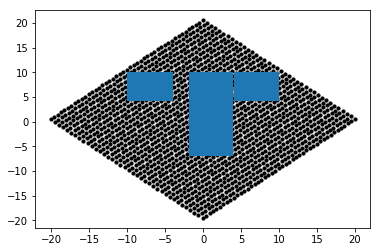

In [4]:
# simulation relation parameters
d = np.array([[ 0.76481], [ 0.64426]])
eps_min = 0.935780510323
M_min = np.array([[ 1.02097, -0.01268],
                  [-0.01268,  1.00766]])
K_min = np.array([[ 0.66149, -0.67953],
                  [-0.69586, -0.7139 ]])
delta = 0.01

abstr = LTIAbstraction(lti_belief, d, un=3, Accuracy=False)

abstr.eps = eps_min
abstr.M = M_min
abstr.K = K_min

abstr.set_regions(regions)
in_regions, nin_regions = abstr.map_dfa_inputs()

fig = plt.figure()
ax0 = fig.add_subplot(111)
abstr.plot(ax0)

# plot regions
for poly in regions.itervalues():
    V = pc.extreme(poly)
    ax0.add_patch(patches.Polygon(V))

print abstr.mdp
print 'before prune: nnz: {}, sparsity: {}'.format(abstr.mdp.nnz(), abstr.mdp.sparsity())
abstr.mdp.prune(1e-6)
print 'after prune: nnz: {}, sparsity: {}'.format(abstr.mdp.nnz(), abstr.mdp.sparsity())

### Construct abstraction x map product system

In [5]:
from best import subsets

def get_regions(s):
    '''compute subsets of possible regions corresponding to abstract state'''   
    if s == abstr.mdp.N-1:
        return set([ (), ])
    
    know_in = []
    know_out = []
    for reg in regions.keys():
        if in_regions[reg][s] == 0:
            know_out.append(reg)
        if nin_regions[reg][s] == 0:
            know_in.append(reg)
    uncertain = list(set(regions.keys()) - set(know_in) - set(know_out))
    return set([ tuple(know_in + unc) for unc in subsets(uncertain)])  

# mapping (s, x_d) -> 2^2^(meas1, meas2, meas3, meas4)
def map_connection(s_xd):
    if s_xd[0] == abstr.mdp.N-1:
        return set([(0,0,0,0)])
    
    current_regs = get_regions(s_xd[0])
    mapstates = []
    
    for regs in current_regs:
        mapstates.append((1 if 'target1meas' in regs else 0, 1 if 'target2meas' in regs else 0, 
                          1 if 'obstacle1meas' in regs else 0, 1 if 'obstacle2meas' in regs else 0))
    
    return set(mapstates)

prod_mdp = abstr.mdp.product(map_mdp, map_connection)
print prod_mdp

s = abstr.closest_abstract((0,2))
map_connection((s, (0,0)))

MDP: 9 inputs "u_d" --> 138591 outputs "((s, x_d), (label0, label1, label2, label3))"


{(0, 0, 0, 1), (0, 0, 1, 1)}

### Set up LTL problem

In [6]:
formula = '! fail U sample'

# map ((s, xd), (label1, label2, label3), fail) -> 2^2^{sample, obstacle}
def abstract_connection(s_xd_lbls):
    s = s_xd_lbls[0][0]
    xd = np.array(s_xd_lbls[0][1]).flatten()
 
    current_regs = get_regions(s)
    
    lbl_t1  = s_xd_lbls[1][0]
    lbl_t2  = s_xd_lbls[1][1]
    lbl_ob1 = s_xd_lbls[1][2]
    lbl_ob2 = s_xd_lbls[1][3]

    ret = []
    
    if all('target1' in reg for reg in current_regs) and lbl_t1 == 'true' or \
       all('target2' in reg for reg in current_regs) and lbl_t2 == 'true':
        # we are in target region and a sample exists
        ret.append('sample')
        
    if any('obstacle1' in reg for reg in current_regs) and lbl_ob1 == 'true' or \
       any('obstacle2' in reg for reg in current_regs) and lbl_ob2 == 'true' or \
        xd[0] is None or \
        np.any(np.abs(xd) > 10):
        # we are in obstacle region and there is an obstacle
        ret.append('fail')
            
    return set([tuple(ret)])

### Solve recursion

In [7]:
from best.ltl import solve_ltl_cosafe

pol = solve_ltl_cosafe(prod_mdp, formula, abstract_connection, delta=delta, algorithm='petter', verbose=True)

iteration 0, time 0.00563812255859
iteration 1, time 3.88903808594
iteration 2, time 7.57422709465
iteration 3, time 11.2622740269
iteration 4, time 15.0662090778
iteration 5, time 18.7257790565
iteration 6, time 22.7418420315
iteration 7, time 26.6002559662
iteration 8, time 30.3462610245
iteration 9, time 34.0309729576
iteration 10, time 37.8619279861
iteration 11, time 41.6893849373
iteration 12, time 45.4371521473
iteration 13, time 49.1823210716
iteration 14, time 52.9973101616
iteration 15, time 56.6720199585
iteration 16, time 60.413490057
iteration 17, time 64.6175200939
iteration 18, time 68.2617330551
iteration 19, time 72.0907981396
iteration 20, time 75.8966150284
iteration 21, time 79.755450964
iteration 22, time 83.5282900333
iteration 23, time 87.3513281345
iteration 24, time 91.234967947
iteration 25, time 95.2315859795
iteration 26, time 99.2448570728
iteration 27, time 103.358405113
iteration 28, time 107.139091015
iteration 29, time 110.928663969
iteration 30, time 1

In [8]:
# define a policy on top of mdp policy
def my_policy(x, mapstate):
    # x: current concrete state [x; y]
    x = np.array(x).reshape((2,1))
    
    lbl_t1 = mapstate[0]
    lbl_t2 = mapstate[1]
    lbl_ob1 = mapstate[2]
    lbl_ob2 = mapstate[3]

    aps = []
    
    if regions['target1'].contains(x) and lbl_t1 == 1 or \
       regions['target2'].contains(x) and lbl_t2 == 1:
        # we are in target region and a sample exists
        aps.append('sample')
        
    if regions['obstacle1'].contains(x) and lbl_ob1 == 1 or \
       regions['obstacle2'].contains(x) and lbl_ob2 == 1:
        # we are in obstacle region and there is an obstacle
        aps.append('fail')
        
    pol.report_aps(aps)
    
    s_list, _ = abstr.all_abstract(x)
    if len(s_list):
        s_idx = np.argmax(pol.V[pol.dfsa_state, s_list])
        s_abstract = s_list[s_idx]
    else:
        s_abstract = len(abstr)
    
    s_tot = prod_mdp.global_state((s_abstract, mapstate))
   
    u_abstract, curr_val = pol.get_input(s_tot)
    
    if curr_val > 0 and u_abstract != -1:
        return abstr.interface(u_abstract, s_abstract, x), curr_val
    else:
        return np.array([[0], [0]]), 0

def my_value(x, mapstate):    
    x = np.array(x).reshape((2,1))
    
    s_abstract = abstr.closest_abstract(x)
    s_tot = prod_mdp.global_state( (s_abstract, mapstate) )

    _, val = pol.get_input(s_tot)
    return val

def my_policy_init(x):
    u, _ = my_policy(x, (0,0,0,0))
    pol.reset()
    return u

pol.reset()

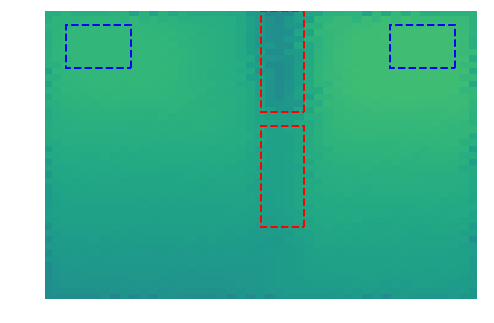

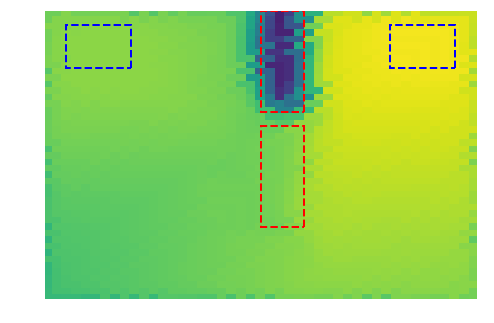

In [9]:
from matplotlib2tikz import save as tikz_save

# figure 1
x_edge = np.linspace(-11,11,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-11,11,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

values = np.array([my_value((x,y), (0,0,0,0)) for (x,y) in zip(xi, yi)])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
ax.set_axis_off()

fig.add_axes(ax)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.pcolor(x_edge, y_edge, values.reshape((49,49)), vmin=0, vmax=1)

ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1']), facecolor='none', linestyle='--', linewidth=2, edgecolor='blue'  ))
ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2']), facecolor='none', linestyle='--', linewidth=2, edgecolor='blue'  ))

ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1']), facecolor='none', linestyle='--', linewidth=2, edgecolor='red'  ))
ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2']), facecolor='none', linestyle='--', linewidth=2, edgecolor='red'  ))

fig.savefig('value1.pdf')


# # figure 2
values = np.array([my_value((x,y), (0,1,0,1)) for (x,y) in zip(xi, yi)])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
ax.set_axis_off()

fig.add_axes(ax)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.pcolor(x_edge, y_edge, values.reshape((49,49)), vmin=0, vmax=1)

ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1']), facecolor='none', linestyle='--', linewidth=2, edgecolor='blue'  ))
ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2']), facecolor='none', linestyle='--', linewidth=2, edgecolor='blue'  ))

ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1']), facecolor='none', linestyle='--', linewidth=2, edgecolor='red'  ))
ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2']), facecolor='none', linestyle='--', linewidth=2, edgecolor='red'  ))

fig.savefig('value2.pdf')


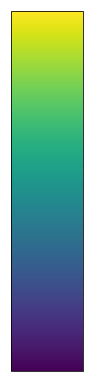

In [10]:
fig = plt.figure(figsize=(1,5))
ax = plt.Axes(fig, [0.,0.,1.,1.])
ax.set_axis_off()

fig.add_axes(ax)

cb1 = matplotlib.colorbar.ColorbarBase(ax)

fig.savefig('cbar.pdf')


### Run simulation 1

reached
reached
reached
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


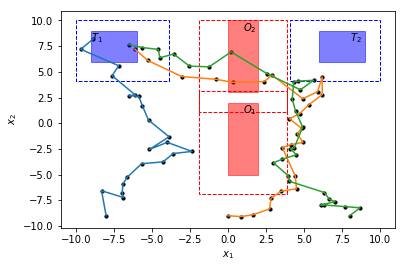

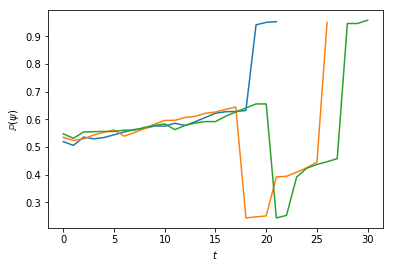

In [11]:
import scipy.linalg as scla
import matplotlib

np.random.seed(10)

time = 90
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)

# plot regions
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1']), color='red', alpha=0.5 ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2']), color='red', alpha=0.5 ))
ax1.text(1, 1, '$O_1$')
ax1.text(1, 9, '$O_2$')

ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1meas']), facecolor='none', linestyle='--', edgecolor='red' ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2meas']), facecolor='none', linestyle='--', edgecolor='red' ))


ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1']), color='blue', alpha=0.5 ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2']), color='blue', alpha=0.5 ))
ax1.text(-9, 8, '$T_1$')
ax1.text(8, 8, '$T_2$')

ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1meas']), facecolor='none', linestyle='--', edgecolor='blue' ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2meas']), facecolor='none', linestyle='--', edgecolor='blue' ))


realmap = [1, 2, 1, 2]   # true map state

Wsqrt = scla.sqrtm(sys_lti.W)
for xinit in range(-8, 9, 8):
    pol.reset()
    mapstate = [0, 0, 0, 0]
    xx = np.array([[xinit],[-9]])
    vv = np.array([my_value(xx, mapstate)])

    for t in range(time): 
        # current state
        xt = xx[:,-1].reshape(2,1)
        # reveal map if within distance
        if regions['target1meas'].contains(xt):
            mapstate[0] = realmap[0]
        if regions['target2meas'].contains(xt):
            mapstate[1] = realmap[1]
        if regions['obstacle1meas'].contains(xt):
            mapstate[2] = realmap[2]
        if regions['obstacle2meas'].contains(xt):
            mapstate[3] = realmap[3]
            
        # next state
        ut, vt = my_policy(xt, mapstate)

        if pol.finished() :
            print('reached')
            break
            
        # update state
        xt1, P1 = belief_mdp.simulate(ut, xt)

        xx = np.hstack([xx, xt1])
        vv = np.hstack([vv, vt])

    if not pol.finished():
        print('not reached')

    ax1.plot(xx[0,:],xx[1,:])
    ax1.scatter(xx[0,:],xx[1,:], color='k', s=10, marker="o")
    
    ax2.plot(range(t+1), vv)

ax1.set_xlabel('$x_1$') 
ax1.set_ylabel('$x_2$') 

ax2.set_xlabel('$t$')
ax2.set_ylabel('$\\mathbb{P}(\\psi)$')

tikz_save('exp1-map.tikz', figure=fig1, figurewidth='\\figurewidth', figureheight='\\figureheight')
tikz_save('exp1-prob.tikz', figure=fig2, figurewidth='\\figurewidth', figureheight='\\figureheight')

### Run simulation 2

reached
reached
reached
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


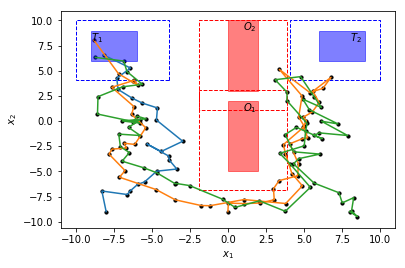

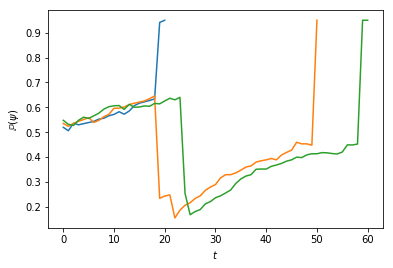

In [12]:
np.random.seed(10)

time = 90
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)

# plot regions
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1']), color='red', alpha=0.5 ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2']), color='red', alpha=0.5 ))
ax1.text(1, 1, '$O_1$')
ax1.text(1, 9, '$O_2$')

ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1meas']), facecolor='none', linestyle='--', edgecolor='red' ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2meas']), facecolor='none', linestyle='--', edgecolor='red' ))


ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1']), color='blue', alpha=0.5 ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2']), color='blue', alpha=0.5 ))
ax1.text(-9, 8, '$T_1$')
ax1.text(8, 8, '$T_2$')

ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1meas']), facecolor='none', linestyle='--', edgecolor='blue' ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2meas']), facecolor='none', linestyle='--', edgecolor='blue' ))


realmap = [1, 2, 1, 1]   # true map state

Wsqrt = scla.sqrtm(sys_lti.W)
for xinit in range(-8, 9, 8):
    pol.reset()
    mapstate = [0, 0, 0, 0]
    xx = np.array([[xinit],[-9]])
    vv = np.array([my_value(xx, mapstate)])

    for t in range(time): 
        # current state
        xt = xx[:,-1].reshape(2,1)
        
        # reveal map if within distance
        if regions['target1meas'].contains(xt):
            mapstate[0] = realmap[0]
        if regions['target2meas'].contains(xt):
            mapstate[1] = realmap[1]
        if regions['obstacle1meas'].contains(xt):
            mapstate[2] = realmap[2]
        if regions['obstacle2meas'].contains(xt):
            mapstate[3] = realmap[3]
        
        # next state
        ut, vt = my_policy(xt, mapstate)

        if pol.finished():
            print('reached')
            break
            
        # update state
        xt1, P1 = belief_mdp.simulate(ut, xt)

        xx = np.hstack([xx, xt1])
        vv = np.hstack([vv, vt])

    if not pol.finished():
        print('not reached')

    ax1.plot(xx[0,:],xx[1,:])
    ax1.scatter(xx[0,:],xx[1,:], color='k', s=10, marker="o")
    
    ax2.plot(range(t+1), vv)

ax1.set_xlabel('$x_1$') 
ax1.set_ylabel('$x_2$') 

ax2.set_xlabel('$t$')
ax2.set_ylabel('$\\mathbb{P}(\\psi)$')

tikz_save('exp2-map.tikz', figure=fig1, figurewidth='\\figurewidth', figureheight='\\figureheight')
tikz_save('exp2-prob.tikz', figure=fig2, figurewidth='\\figurewidth', figureheight='\\figureheight')

In [13]:
prod_mdp.det_list
prod_mdp.mdplist
np.sum(prod_mdp.conn_list[0], 0)

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])